<a href="https://colab.research.google.com/github/prudhvi6e/Playing-card-detection/blob/main/identifying_playing_cards.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this project I'll use Alexnet in order to identify playing cards in a complete identification (ace of clubs. 52 categories)

# **Import Libraries**

In [ ]:
import torch
import torchvision
print(torch.__version__)
from PIL import Image
from torch.utils.data import Dataset
import os
from torchvision import transforms
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

1.9.1


In [ ]:
#hyper parameters:
RANDOM_SEED = 123
BATCH_SIZE = 32
NUM_EPOCHS = 256
num_epochs = 256
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# **EDA**

In [ ]:
df= pd.read_csv(os.path.join(path,'train_labels.csv'))

In [ ]:
#conversion to int dict:

full_dict={'ace of spades': 0, 'two of spades':1, 'three of spades':2, 'four of spades':3, 'five of spades':4, 'six of spades':5, 'seven of spades':6,
      'eight of spades':7, 'nine of spades':8, 'ten of spades':9, 'jack of spades':10, 'queen of spades':11, 'king of spades':12,
      'ace of hearts': 13, 'two of hearts': 14, 'three of hearts': 15, 'four of hearts': 16, 'five of hearts': 17, 'six of hearts': 18,
      'seven of hearts':19, 'eight of hearts':20, 'nine of hearts':21, 'ten of hearts':22, 'jack of hearts': 23, 'queen of hearts': 24,
      'king of hearts':25,
      'ace of clubs': 26, 'two of clubs': 27, 'three of clubs': 28, 'four of clubs': 29, 'five of clubs': 30, 'six of clubs': 31,
      'seven of clubs':32, 'eight of clubs':33, 'nine of clubs':34, 'ten of clubs':35, 'jack of clubs': 36, 'queen of clubs': 37,
      'king of clubs':38,
      'ace of diamonds': 39, 'two of diamonds': 40, 'three of diamonds': 41, 'four of diamonds': 42, 'five of diamonds': 43, 'six of diamonds': 44,
      'seven of diamonds':45, 'eight of diamonds':46, 'nine of diamonds':47, 'ten of diamonds':48, 'jack of diamonds': 49, 'queen of diamonds': 50,
      'king of diamonds':51
           
}

In [ ]:
df['class_number'] = df['class'].map(full_dict)
df.loc[df['class_number'].isnull()]

filename  width  height           class  xmin  ymin  xmax  ymax  \
4    C710.jpg    183     275  seven of seven    12    19   170   258   
47    C82.png    194     259  eigth of clubs    10     9   182   252   
160   C91.jpg    181     279  eigth of clubs     4     1   179   258   
168   C87.jpg    186     270  eigth of clubs    19    17   168   250   
202   C83.jpg    183     275  eigth of clubs    12    19   170   258   
234   C81.jpg    193     262  eigth of clubs     4     1   188   260   
257   C89.jpg    185     273  eigth of clubs     5     2   179   253   
346   C86.png    189     267  eigth of clubs     1     2   189   254   
348   C88.png    204     247  eigth of clubs    16    13   172   232   
414   C85.jpg    275     183  eigth of clubs    35    28   130   176   
476   C84.png    201     251  eigth of clubs     3     3   198   251   

     class_number  
4             NaN  
47            NaN  
160           NaN  
168           NaN  
202           NaN  
234           NaN  
257           NaN  
346           NaN  
348           NaN  
414           NaN  
476           NaN

We can see that there are to kinds of nulls:
1. eigth of clubs
2. seven of seven

The former is clearly eight of clubs, and after checking, the latter is seven of clubs, so I just added them to the class dictionrary, and we are good to go.

# **Complete Identification**

> **Data Loader and Dataset**

In [ ]:
#conversion to int dict:

full_dict={'ace of spades': 0, 'two of spades':1, 'three of spades':2, 'four of spades':3, 'five of spades':4, 'six of spades':5, 'seven of spades':6,
      'eight of spades':7, 'nine of spades':8, 'ten of spades':9, 'jack of spades':10, 'queen of spades':11, 'king of spades':12,
      'ace of hearts': 13, 'two of hearts': 14, 'three of hearts': 15, 'four of hearts': 16, 'five of hearts': 17, 'six of hearts': 18,
      'seven of hearts':19, 'eight of hearts':20, 'nine of hearts':21, 'ten of hearts':22, 'jack of hearts': 23, 'queen of hearts': 24,
      'king of hearts':25,
      'ace of clubs': 26, 'two of clubs': 27, 'three of clubs': 28, 'four of clubs': 29, 'five of clubs': 30, 'six of clubs': 31,
      'seven of clubs':32, 'seven of seven':32, 'eight of clubs':33, 'eigth of clubs':33, 'nine of clubs':34, 'ten of clubs':35, 'jack of clubs': 36, 'queen of clubs': 37,
      'king of clubs':38,
      'ace of diamonds': 39, 'two of diamonds': 40, 'three of diamonds': 41, 'four of diamonds': 42, 'five of diamonds': 43, 'six of diamonds': 44,
      'seven of diamonds':45, 'eight of diamonds':46, 'nine of diamonds':47, 'ten of diamonds':48, 'jack of diamonds': 49, 'queen of diamonds': 50,
      'king of diamonds':51
           
}

In [ ]:
class MyDataset(Dataset):

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.img_names = df['filename']
        self.y = df['class'].map(full_dict)
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index])).convert('RGB')#to convert grayscale images to RGB.
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [ ]:
#Loading the pictures data
path = '../input/object-detection-dataset-standard-52card-deck'


PATH_OF_DATA = os.path.join(path,'train/train')
TEST_PATH_OF_DATA = os.path.join(path,'test/test')
print(PATH_OF_DATA)

../input/object-detection-dataset-standard-52card-deck/train/train


In [ ]:
#Transformers
custom_transform = transforms.Compose([#transforms.Lambda(lambda x: x/255.),# not necessary
                                       transforms.Resize((256, 256)),
                                       transforms.RandomCrop((224, 224)),
                                       #transforms.ColorJitter(brightness=0.5),
                                       transforms.RandomRotation(degrees=45),
                                       transforms.RandomHorizontalFlip(p=0.1),
                                       #transforms.RandomVerticalFlip(p=0.5),
                                       #transforms.RandomGrayscale(p=0.05),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))
                                      ])

test_transforms = transforms.Compose([#transforms.Lambda(lambda x: x/255.),# not necessary
                                       transforms.Resize((256, 256)),
                                       transforms.RandomCrop((224, 224)),
                                       #transforms.ColorJitter(brightness=0.5),
                                       #transforms.RandomRotation(degrees=45),
                                       #transforms.RandomHorizontalFlip(p=0.1),
                                       #transforms.RandomVerticalFlip(p=0.5),
                                       #transforms.RandomGrayscale(p=0.05),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))
                                      ])

In [ ]:
df.nunique()

filename    539
width       160
height      142
class        52
xmin        137
ymin        119
xmax        226
ymax        263
dtype: int64

In [ ]:
train_dataset = MyDataset(csv_path=os.path.join(path,'train_labels.csv'),
                          img_dir=PATH_OF_DATA,
                          transform=custom_transform)

In [ ]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          drop_last=True,
                          shuffle=True, # want to shuffle the dataset
                          num_workers=2) # number processes/CPUs to use

In [ ]:
    valid_dataset = MyDataset(
        csv_path=os.path.join(path,'train_labels.csv'),
        img_dir=PATH_OF_DATA,
        transform=test_transforms)

    valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=12,
        shuffle=False,
        num_workers=2)

In [ ]:
    test_dataset = MyDataset(
        csv_path=os.path.join(path,'test_labels.csv'),
        img_dir=TEST_PATH_OF_DATA,
        transform=test_transforms)

    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2)

> **Checking the Data**

In [ ]:
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Image batch dimensions: torch.Size([32, 3, 224, 224])
Image label dimensions: torch.Size([32])
Class labels of 10 examples: tensor([ 2,  5,  1, 43, 16, 11, 42, 32, 51, 37])


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

num_epochs = 2
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(device)
        y = y.to(device)

Epoch: 1 | Batch index: 0 | Batch size: 32
Epoch: 1 | Batch index: 1 | Batch size: 32
Epoch: 1 | Batch index: 2 | Batch size: 32
Epoch: 1 | Batch index: 3 | Batch size: 32
Epoch: 1 | Batch index: 4 | Batch size: 32
Epoch: 1 | Batch index: 5 | Batch size: 32
Epoch: 1 | Batch index: 6 | Batch size: 32
Epoch: 1 | Batch index: 7 | Batch size: 32
Epoch: 1 | Batch index: 8 | Batch size: 32
Epoch: 1 | Batch index: 9 | Batch size: 32
Epoch: 1 | Batch index: 10 | Batch size: 32
Epoch: 1 | Batch index: 11 | Batch size: 32
Epoch: 1 | Batch index: 12 | Batch size: 32
Epoch: 1 | Batch index: 13 | Batch size: 32
Epoch: 1 | Batch index: 14 | Batch size: 32
Epoch: 1 | Batch index: 15 | Batch size: 32
Epoch: 2 | Batch index: 0 | Batch size: 32
Epoch: 2 | Batch index: 1 | Batch size: 32
Epoch: 2 | Batch index: 2 | Batch size: 32
Epoch: 2 | Batch index: 3 | Batch size: 32
Epoch: 2 | Batch index: 4 | Batch size: 32
Epoch: 2 | Batch index: 5 | Batch size: 32
Epoch: 2 | Batch index: 6 | Batch size: 32
Epoch

Text(0.5, 0.98, 'Augmented training set images')

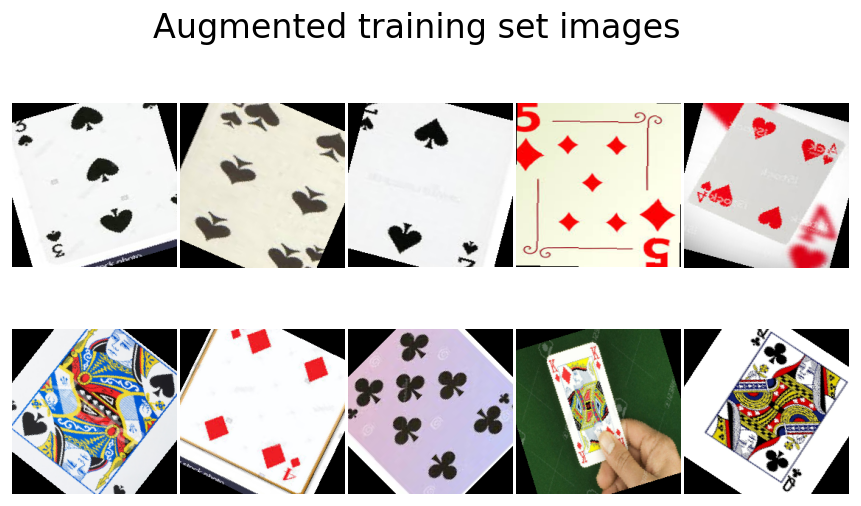

In [ ]:
example_rows = 2
example_cols = 5

#sampler = torch.utils.data.RandomSampler(train_dataset)

# Get a batch of images and labels  
#images, indices = next(iter(sampler)) 

plt.rcParams['figure.dpi'] = 120  # Increase size of pyplot plots

# Show a grid of example images    
fig, axes = plt.subplots(example_rows, example_cols, figsize=(9, 5)) #  sharex=True, sharey=True)
axes = axes.flatten()


for ax, image in zip(axes, images):
    #ii=0
    #ax.imshow(np.uint8((image.cpu().numpy().transpose((1, 2, 0)))))
    ax.imshow(image.cpu().numpy().transpose((1, 2, 0)))
    ax.set_axis_off()
    #ax.set_title(f'T: {images(targets[1])}')
    #ax.set_title(train_dataset.y[ii], fontsize=7)
    #ii+=1


fig.subplots_adjust(wspace=0.02, hspace=0)
fig.suptitle('Augmented training set images', fontsize=20)
#plt.show()

> **Functions**

In [ ]:
def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):            
        features = features.to(device)
        targets = targets.to(device)
        logits = model(features)
        _, predicted_labels = torch.max(logits, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [ ]:
import time
import torch



def train_model(model, num_epochs, train_loader,
                valid_loader, test_loader, optimizer, device):

    start_time = time.time()
    minibatch_loss_list, train_acc_list, valid_acc_list = [], [], []
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(device)
            targets = targets.to(device, dtype=torch.int64)

            # ## FORWARD AND BACK PROP
            logits = model(features)
            loss = torch.nn.functional.cross_entropy(logits, targets)
            optimizer.zero_grad()

            loss.backward()

            # ## UPDATE MODEL PARAMETERS
            optimizer.step()

            # ## LOGGING
            minibatch_loss_list.append(loss.item())
            if batch_idx % 50:
                print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
                      f'| Batch {batch_idx+1:04d}/{len(train_loader):04d} '
                      f'| Loss: {loss:.4f}')
#################################################################################################################################
        model.eval()
        with torch.no_grad():  # save memory during inference
            train_acc = compute_accuracy(model, train_loader#, device=device
                                         )
            valid_acc = compute_accuracy(model, valid_loader#, device=device
                                         )
            print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
                  f'| Train: {train_acc :.2f}% '
                  f'| Validation: {valid_acc :.2f}%')
            train_acc_list.append(train_acc.item())
            valid_acc_list.append(valid_acc.item())

        elapsed = (time.time() - start_time)/60
        print(f'Time elapsed: {elapsed:.2f} min')

    elapsed = (time.time() - start_time)/60
    print(f'Total Training Time: {elapsed:.2f} min')

    #test_acc = compute_accuracy(model, test_loader#, device=device)
    #print(f'Test accuracy {test_acc :.2f}%')

    return minibatch_loss_list, train_acc_list, valid_acc_list

In [ ]:
# imports from installed libraries
import os
import matplotlib.pyplot as plt
import numpy as np
import torch


def plot_training_loss(minibatch_loss_list, num_epochs, iter_per_epoch,
                       results_dir=None, averaging_iterations=100):

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(range(len(minibatch_loss_list)),
             (minibatch_loss_list), label='Minibatch Loss')

    if len(minibatch_loss_list) > 1000:
        ax1.set_ylim([
            0, np.max(minibatch_loss_list[1000:])*1.5
            ])
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')

    ax1.plot(np.convolve(minibatch_loss_list,
                         np.ones(averaging_iterations,)/averaging_iterations,
                         mode='valid'),
             label='Running Average')
    ax1.legend()

    ###################
    # Set scond x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))

    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())
    ###################

    plt.tight_layout()

    if results_dir is not None:
        image_path = os.path.join(results_dir, 'plot_training_loss.pdf')
        plt.savefig(image_path)


def plot_accuracy(train_acc_list, valid_acc_list, results_dir):

    num_epochs = len(train_acc_list)

    plt.plot(np.arange(1, num_epochs+1),
             train_acc_list, label='Training')
    plt.plot(np.arange(1, num_epochs+1),
             valid_acc_list, label='Validation')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()

    if results_dir is not None:
        image_path = os.path.join(
            results_dir, 'plot_acc_training_validation.pdf')
        plt.savefig(image_path)


def show_examples(model, data_loader):

    for batch_idx, (features, targets) in enumerate(data_loader):

        with torch.no_grad():
            features = features
            targets = targets
            logits = model(features)
            predictions = torch.argmax(logits, dim=1)
        break

    fig, axes = plt.subplots(nrows=3, ncols=5,
                             sharex=True, sharey=True)

    nhwc_img = np.transpose(features, axes=(0, 2, 3, 1))
    nhw_img = np.squeeze(nhwc_img.numpy(), axis=3)

    for idx, ax in enumerate(axes.ravel()):
        ax.imshow(nhw_img[idx], cmap='binary')
        ax.title.set_text(f'P: {predictions[idx]} | T: {targets[idx]}')
        ax.axison = False

    plt.tight_layout()
    plt.show()

> **AlexNet**

In [ ]:
class AlexNet(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(3, 256, kernel_size=11, stride=4, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            #
            torch.nn.Conv2d(256, 192, kernel_size=5, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            #
            torch.nn.Conv2d(192, 384, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            #
            torch.nn.Conv2d(384, 256, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            #
            torch.nn.Conv2d(256, 256, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = torch.nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(256 * 6 * 6, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        logits = self.classifier(x)
        return logits

> **setting the architeture**

In [ ]:
model = AlexNet(num_classes=52)

model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

> **Training the model and results**

In [ ]:
#Training the Model
minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE, 
    )

Epoch: 001/256 | Batch 0002/0016 | Loss: 3.9488
Epoch: 001/256 | Batch 0003/0016 | Loss: 3.9535
Epoch: 001/256 | Batch 0004/0016 | Loss: 3.9512
Epoch: 001/256 | Batch 0005/0016 | Loss: 3.9542
Epoch: 001/256 | Batch 0006/0016 | Loss: 3.9519
Epoch: 001/256 | Batch 0007/0016 | Loss: 3.9527
Epoch: 001/256 | Batch 0008/0016 | Loss: 3.9496
Epoch: 001/256 | Batch 0009/0016 | Loss: 3.9515
Epoch: 001/256 | Batch 0010/0016 | Loss: 3.9527
Epoch: 001/256 | Batch 0011/0016 | Loss: 3.9504
Epoch: 001/256 | Batch 0012/0016 | Loss: 3.9521
Epoch: 001/256 | Batch 0013/0016 | Loss: 3.9534
Epoch: 001/256 | Batch 0014/0016 | Loss: 3.9502
Epoch: 001/256 | Batch 0015/0016 | Loss: 3.9534
Epoch: 001/256 | Batch 0016/0016 | Loss: 3.9513
Epoch: 001/256 | Train: 1.76% | Validation: 1.30%
Time elapsed: 0.20 min
Epoch: 002/256 | Batch 0002/0016 | Loss: 3.9473
Epoch: 002/256 | Batch 0003/0016 | Loss: 3.9511
Epoch: 002/256 | Batch 0004/0016 | Loss: 3.9478
Epoch: 002/256 | Batch 0005/0016 | Loss: 3.9502
Epoch: 002/256 

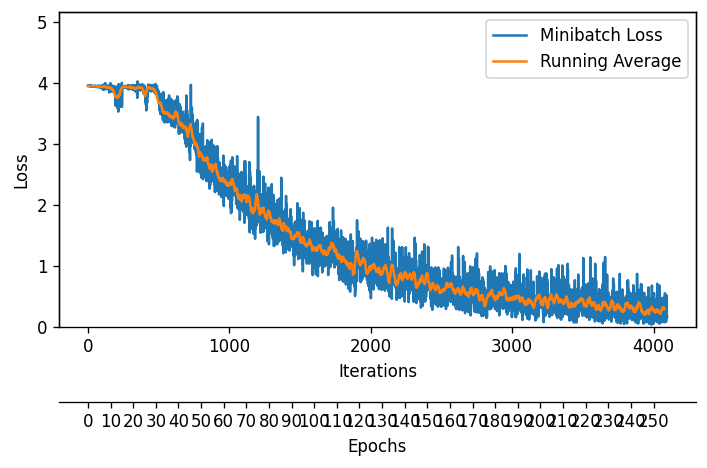

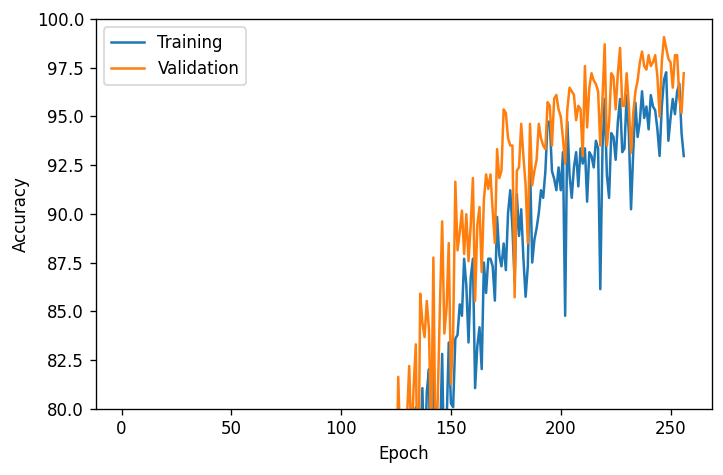

In [ ]:
plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=20)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([80, 100])
plt.show()

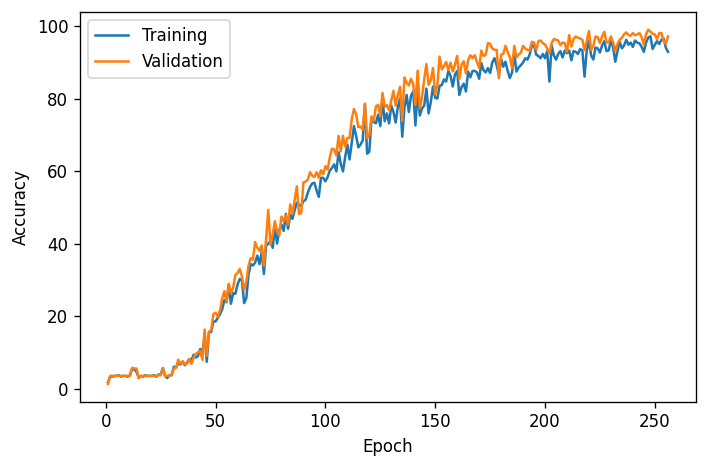

In [ ]:
plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)

In [ ]:
#reverse dict:

rev_dict={0: 'ace of spades', 1: 'two of spades', 2: 'three of spades', 3: 'four of spades', 4: 'five of spades', 5: 'six of spades', 6: 'seven of spades',
      7: 'eight of spades', 8: 'nine of spades', 9: 'ten of spades', 10: 'jack of spades', 11: 'queen of spades', 12: 'king of spades',
      13: 'ace of hearts', 14: 'two of hearts', 15: 'three of hearts', 16: 'four of hearts', 17: 'five of hearts', 18: 'six of hearts',
      19: 'seven of hearts', 20: 'eight of hearts', 21: 'nine of hearts', 22: 'ten of hearts', 23: 'jack of hearts', 24: 'queen of hearts',
      25: 'king of hearts',
      26: 'ace of clubs', 27: 'two of clubs', 28: 'three of clubs', 29: 'four of clubs', 30: 'five of clubs', 31: 'six of clubs',
      32: 'seven of clubs', 33: 'eight of clubs', 34: 'nine of clubs', 35: 'ten of clubs', 36: 'jack of clubs', 37: 'queen of clubs',
      38: 'king of clubs',
      39: 'ace of diamonds', 40: 'two of diamonds', 41: 'three of diamonds', 42: 'four of diamonds', 43: 'five of diamonds', 44: 'six of diamonds',
      45: 'seven of diamonds', 46: 'eight of diamonds', 47: 'nine of diamonds', 48: 'ten of diamonds', 49: 'jack of diamonds', 50: 'queen of diamonds',
      51: 'king of diamonds'
           
}

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f63947533b0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f63947533b0>Traceback (most recent call last):

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
        self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
self._shutdown_workers()
    if w.is_alive():  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers

  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
        if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can o

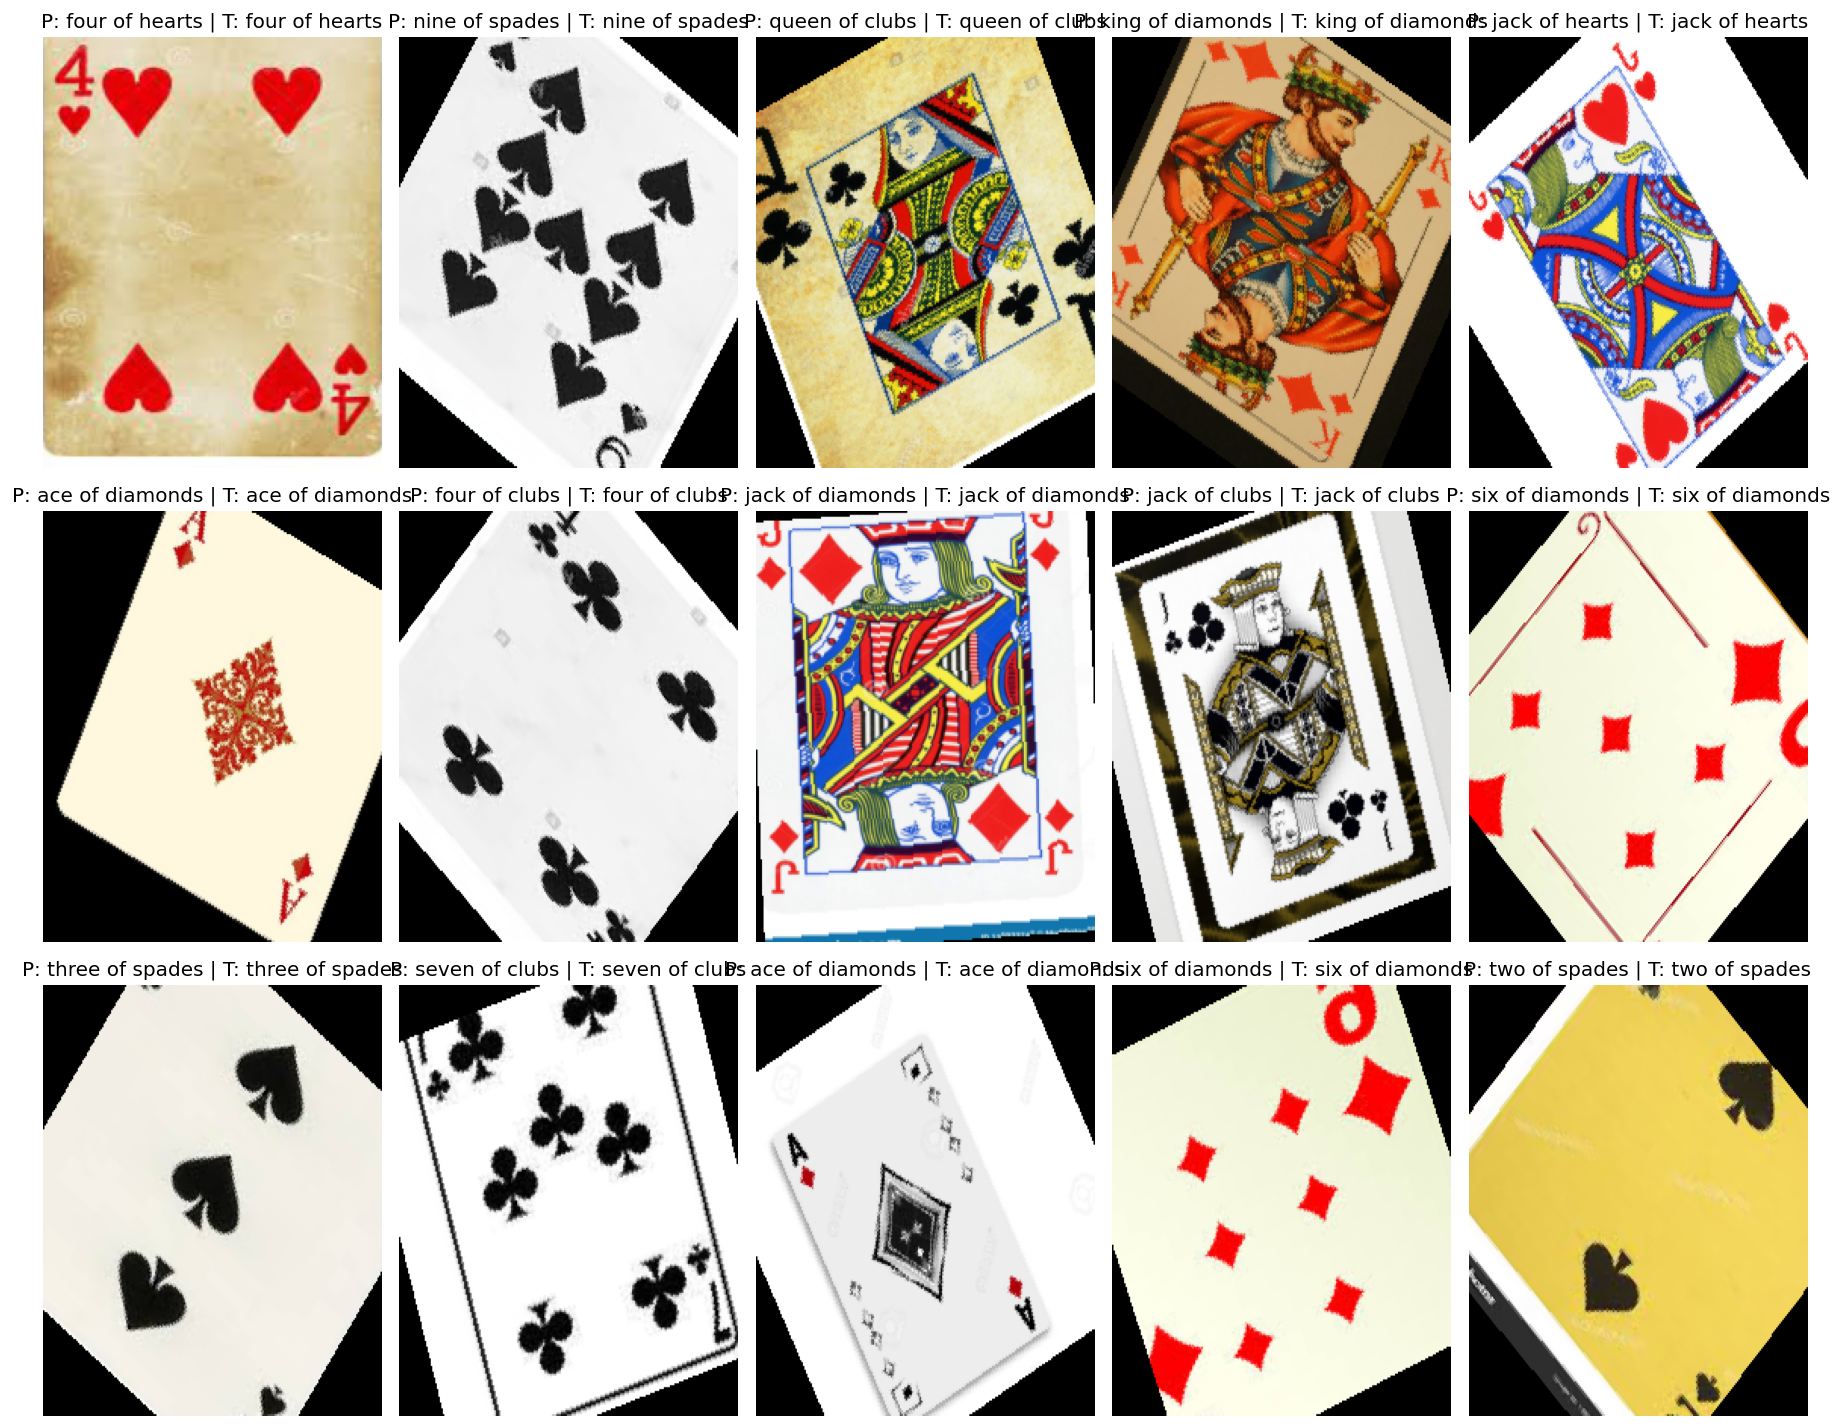

In [ ]:
for batch_idx, (features, targets) in enumerate(train_loader):

    with torch.no_grad():
        features = features
        targets = targets
        logits = model(features.cuda())
        predictions = torch.argmax(logits, dim=1)
    break

fig, axes = plt.subplots(nrows=3, ncols=5,
                          sharex=True, sharey=True, figsize=(15,12
                                                             ))

nhwc_img = np.transpose(features, axes=(0, 2, 3, 1))
#nhwc_img = np.transpose(features, axes=(0, 2, 1))
#nhw_img = np.squeeze(nhwc_img.numpy(), axis=1)

for idx, ax in enumerate(axes.ravel()):
    ax.imshow(nhwc_img[idx], cmap='binary', aspect='auto')
    ax.title.set_text(f'P: {rev_dict[predictions[idx].item()]} | T: {rev_dict[predictions[idx].item()]}')
    ax.axison = False

plt.tight_layout()
plt.show()

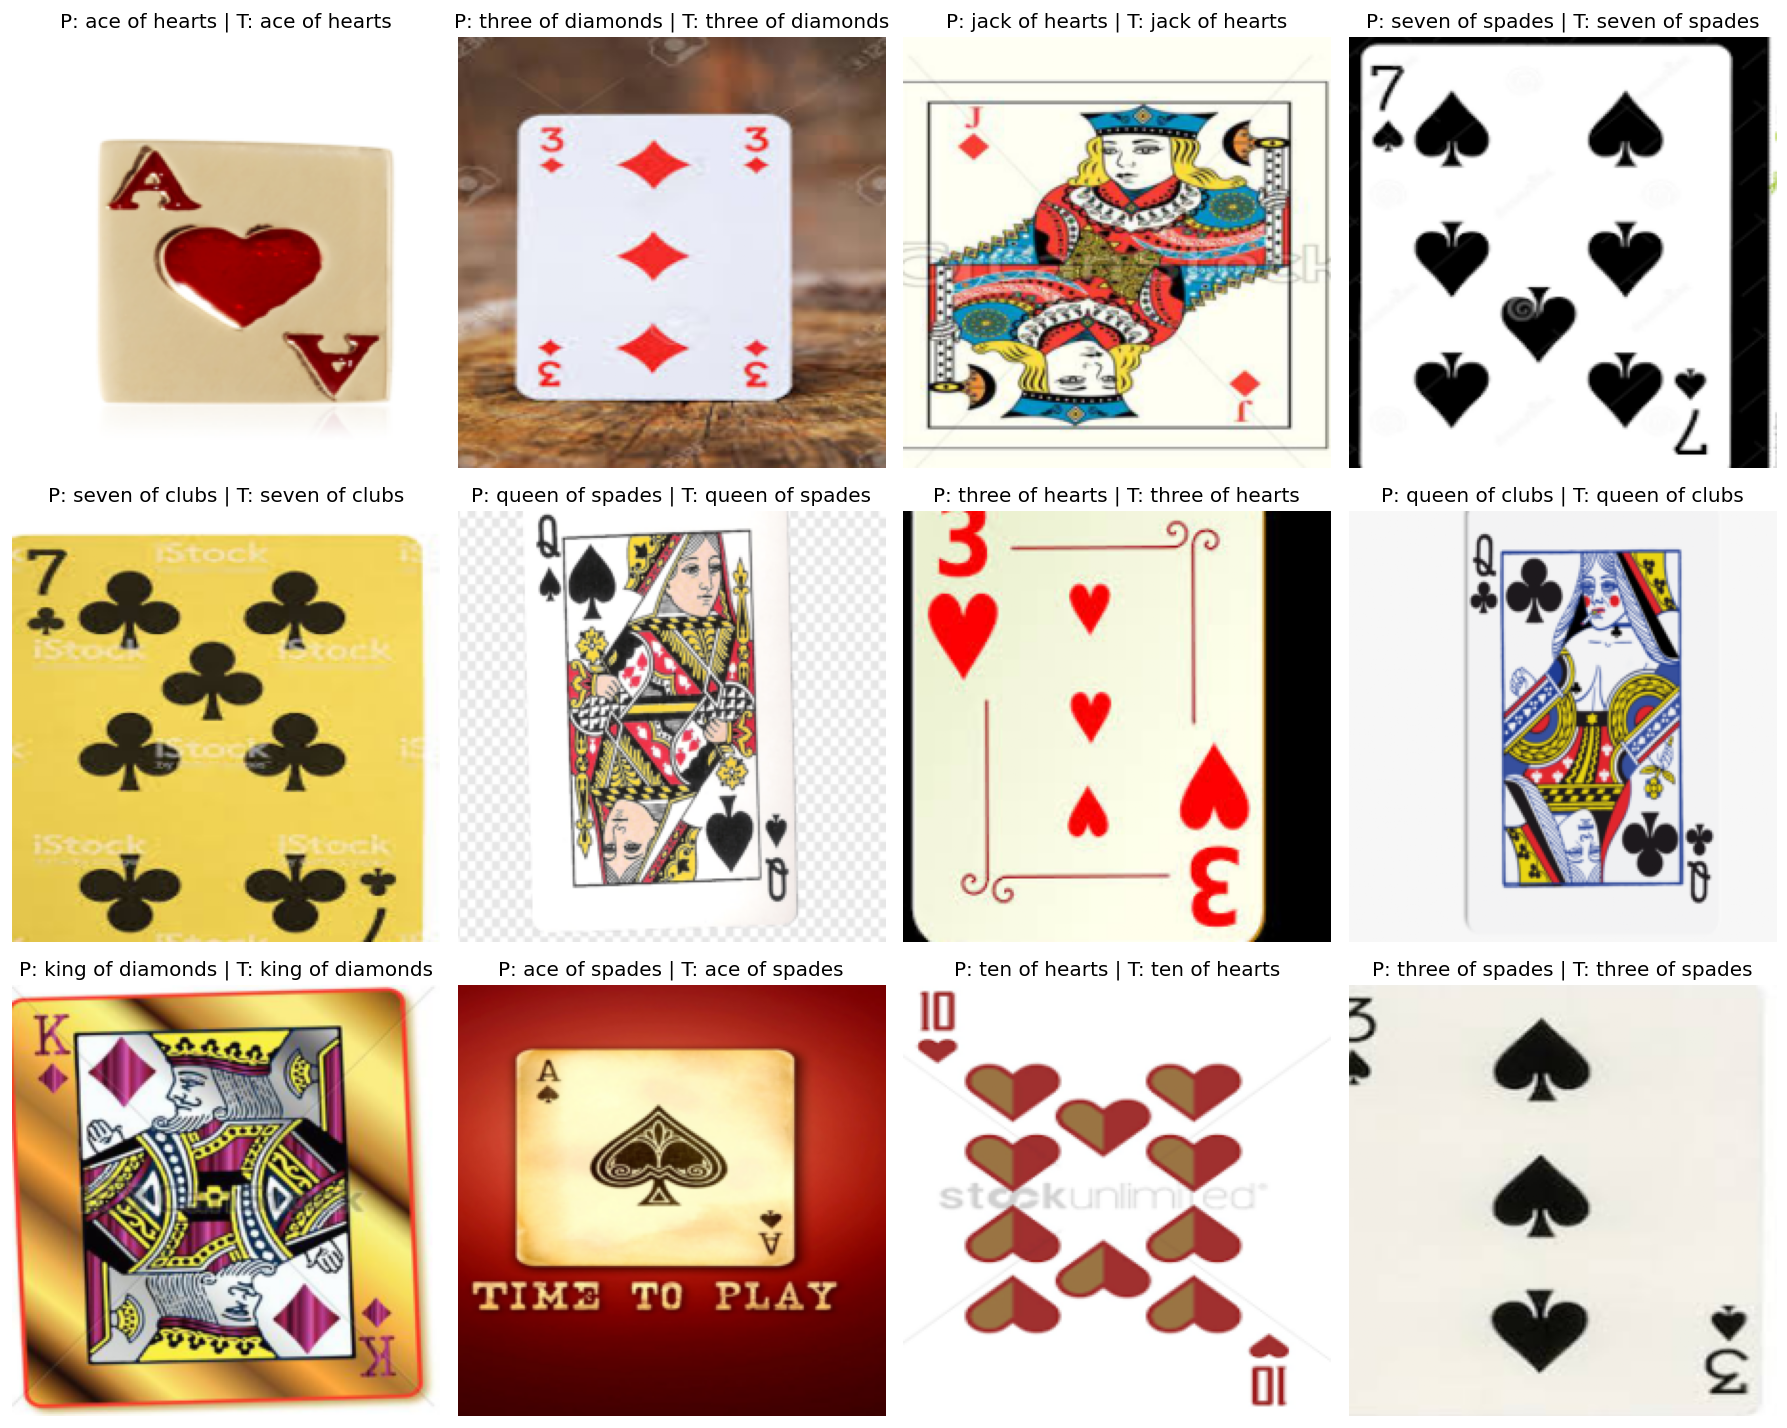

In [ ]:
for batch_idx, (features, targets) in enumerate(valid_loader):

    with torch.no_grad():
        features = features
        targets = targets
        logits = model(features.cuda())
        predictions = torch.argmax(logits, dim=1)
    break

fig, axes = plt.subplots(nrows=3, ncols=4,
                          sharex=True, sharey=True, figsize=(15,12
                                                             ))

nhwc_img = np.transpose(features, axes=(0, 2, 3, 1))
#nhwc_img = np.transpose(features, axes=(0, 2, 1))
#nhw_img = np.squeeze(nhwc_img.numpy(), axis=1)

for idx, ax in enumerate(axes.ravel()):
    ax.imshow(nhwc_img[idx], cmap='binary', aspect='auto')
    ax.title.set_text(f'P: {rev_dict[predictions[idx].item()]} | T: {rev_dict[predictions[idx].item()]}')
    ax.axison = False

plt.tight_layout()
plt.show()